# 1. Imports and prequesites

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Runs on GPU if available, otherwise runs on CPU

# 2. Understand the environment

In [2]:
"""
Unimportant parameters of environment:
m = 1.0 
dt = 0.05 distance time 
l = 1.0 rod length

Important parameters of environment:
th = angle in radians normalized between [-pi, pi] with 0 being in the upright position
thdot = angular velocity of free end
x = cos(th) aka coordinate of free end
y = sin(th) aka coordinate of free end
u = torque in Nm (+ve counter-clockwise) applied to free end. Will clip e.g. if 3, will clip to 2.
g = acceleration of gravity in m**2. Default value is 10.0. Can change e.g. gym.make('Pendulum-v1', g=9.81)

Observation space:
| 0   | x         | -1.0 | 1.0 |
| 1   | y         | -1.0 | 1.0 |
| 2   | thdot     | -8.0 | 8.0 |

Action space: 
| 0   | u       | -2.0 | 2.0 |

Transition dynamics (clips if outside bounds)
new_thdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
new_th = th + newthdot * dt

Reward:
r = -(th**2 + 0.1 * thdot**2 + 0.001 * u**2)
Min reward = -(pi**2 + 0.1 * 8**2 + 0.001 * 2**2) = -16.2736044
Max reward = 0 when upright with zero velocity and no torque applied 

Starting state:
Random theta in [-pi, pi] and a random theta_dt in [-1,1]

Termination:
Episode terminates at 200 time steps and will never terminate before this even if upright
"""

env = gym.make('Pendulum-v1')
env.seed(0)
print('Start state:', env.reset())
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)
print('Step:', env.step([1.25])) # Returns: new x, new y, new thdot, reward, done (which is always false)
print('State:', env.state) # Returns: new_th and new_thdot
action = env.action_space.sample()
print('Action list:', action)
print('Action item:', action.item())

Start state: [-0.9422352  -0.33495203  0.9307819 ]
Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space: Box([-2.], [2.], (1,), float32)
Step: (array([-0.9268331, -0.3754736,  0.8670679], dtype=float32), -7.928412733658928, False, {})
State: [-2.75668495  0.86706786]
Action list: [-1.2162052]
Action item: -1.2162052392959595


# 3. Define the neural network(s)

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, s_size, h_size, a_size):
        super(PolicyNetwork, self).__init__() 
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = F.softmax(self.fc2(x), dim=1) #tanh to scale for standard normal distribution?
        sigma = F.softplus(self.fc2(x)) #If mu changes to close to bound, variance needs to increase so that all actions covered?
        return mu, sigma
    
    # Create .act(state) method so don't need to convert tensor to np repeatedly
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) #Turn state to tensor
        mu, sigma = self.forward(state) #Input state to neural network
        m = Normal(mu, sigma) #Output normal probability distribution for continuous action space       
        action = m.sample() #Choose an action from this distribution
        return action.item(), m.log_prob(action)

# 4. Instantiate the neural network(s)

In [4]:
# s_size=3 since 3 elements in the observation space (x, y, velocity) to input to neural network
# h_size=64 arbitrarily
# a_size=1 since continous -> Use DiagGaussianDistribution?
policy = PolicyNetwork(s_size = 3, h_size = 64, a_size = 1).to(device)

optimizer = optim.Adam(policy.parameters(), lr=1e-2) #Use adam gradient ascent algorithm 

# 5. Define the algorithm to be used

In [5]:
def reinforce(n_episodes=1000, max_t=200, gamma=1.0, print_every=10):

    scores = [] # Stores all episode rewards
    scores_deque = deque(maxlen=print_every) #Stores episode reward from last 10 episodes and prints average
    
    for i_episode in range(1, n_episodes+1):
    
        state = env.reset()
        
        discounted_rewards = []
        saved_log_probs = [] #Stores log(policy) for each timestep
        
        for t in range(max_t): 
            action, log_prob = policy.act(state) #Input current state to neural network
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step([action]) #Multiply action by 2 to rescale for environment? Why square brackets?
            discounted_reward = reward*(gamma**t)
            discounted_rewards.append(discounted_reward)
        
        G = sum(discounted_rewards)
        scores_deque.append(G) #Append total discounted reward for each episode 
        scores.append(G)
        
        rewards_togo = []
        for t in range(max_t): 
            rewards_togo.append(sum(discounted_rewards))
            discounted_rewards.pop(0)
        
        policy_loss = [] #Stores -log(pi) * rewards_togo for each timestep. Negative as gradient descent
        
        for t in range(max_t): 
            policy_loss.append(-saved_log_probs[t] * rewards_togo[t])
        
        policy_loss = torch.cat(policy_loss).sum() #Concatenates then sums the list?
        optimizer.zero_grad() #Sets the gradients of all optimized tensors to 0?
        policy_loss.backward() #Computes policy gradients with respect to all parameters?
        optimizer.step() #Update the parameters in the neural network
        
        if i_episode % print_every == 0: 
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

# 6. Train the agent and plot rewards over episodes

Episode 10	Average Score: -1457.90
Episode 20	Average Score: -1245.35
Episode 30	Average Score: -1528.42
Episode 40	Average Score: -1361.07
Episode 50	Average Score: -1241.93
Episode 60	Average Score: -1294.48
Episode 70	Average Score: -1265.02
Episode 80	Average Score: -1256.66
Episode 90	Average Score: -1220.23
Episode 100	Average Score: -1204.52
Episode 110	Average Score: -1305.31
Episode 120	Average Score: -1251.62
Episode 130	Average Score: -1193.92
Episode 140	Average Score: -1390.62
Episode 150	Average Score: -1419.39
Episode 160	Average Score: -1297.14
Episode 170	Average Score: -1398.66
Episode 180	Average Score: -1347.64
Episode 190	Average Score: -1272.49
Episode 200	Average Score: -1444.23
Episode 210	Average Score: -1097.59
Episode 220	Average Score: -1222.11
Episode 230	Average Score: -1329.93
Episode 240	Average Score: -1243.62
Episode 250	Average Score: -1323.12
Episode 260	Average Score: -1326.97
Episode 270	Average Score: -1242.65
Episode 280	Average Score: -1215.10
E

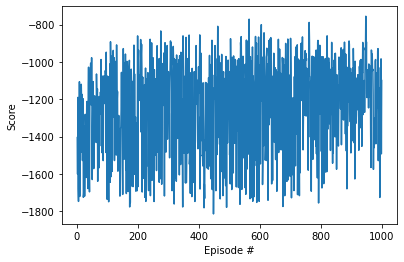

In [6]:
scores = reinforce()

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# 7. Test the trained agent for 1 episode

In [7]:
state = env.reset()
for t in range(200):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step([action])

env.close()

2022-04-20 13:05:20.803 python[20041:4385745] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7f42addae0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-20 13:05:20.804 python[20041:4385745] Warning: Expected min height of view: (<NSButton: 0x7f7f434852f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-20 13:05:20.806 python[20041:4385745] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7f43485c40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-20 13:05:20.808 python[20041:4385745] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7f43488450>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


# Debug

In [8]:
state = env.reset()

discounted_rewards = []
rewards_togo = []

for t in range(5):
    env.render()
    state, reward, done, _ = env.step([-2])
    discounted_reward = reward*gamma**t
    discounted_rewards.append(discounted_reward)
    
env.close()

2022-04-20 13:05:24.675 python[20041:4385745] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7f434b0430>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-20 13:05:24.675 python[20041:4385745] Warning: Expected min height of view: (<NSButton: 0x7f7f41573d60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-20 13:05:24.678 python[20041:4385745] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7f41574260>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-20 13:05:24.680 python[20041:4385745] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f7f412de570>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


NameError: name 'gamma' is not defined